In [1]:
import seaborn as sns

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pathlib import Path

In [2]:
text_df = pd.read_json("text_performance.jsonl", orient="records", lines=True)
audio_df = pd.read_json("audio_performance.jsonl", orient="records", lines=True)

df = pd.concat([text_df, audio_df])
df = df.reset_index()

In [3]:
df.head()

,level_0,class,score_type,value,level,binary,is_baseline,model_name,split,target_class,type,index,origin,prediction
0,0,overall,acc,0.60177,overall,1,0,DEPR_ScandiBERT_lr-0.0001_wdecay-0.001_wsteps-...,val,DEPR,text,NaN,NaN,NaN
1,1,overall,f1_macro,0.60127,overall,1,0,DEPR_ScandiBERT_lr-0.0001_wdecay-0.001_wsteps-...,val,DEPR,text,NaN,NaN,NaN
2,2,overall,f1_micro,0.60177,overall,1,0,DEPR_ScandiBERT_lr-0.0001_wdecay-0.001_wsteps-...,val,DEPR,text,NaN,NaN,NaN
3,3,overall,precision_macro,0.604048,overall,1,0,DEPR_ScandiBERT_lr-0.0001_wdecay-0.001_wsteps-...,val,DEPR,text,NaN,NaN,NaN
4,4,overall,precision_micro,0.60177,overall,1,0,DEPR_ScandiBERT_lr-0.0001_wdecay-0.001_wsteps-...,val,DEPR,text,NaN,NaN,NaN


In [4]:
# only keep id-level
df = df[df["level"] == "id"]

# only plot test scores and f1-macro for now
df_test = df[(df["score_type"] == "f1_macro") & (df["split"] == "test")]

# split into baseline and transformers for plotting
baselines = df_test[df_test["is_baseline"] == 1]
transformers = df_test[df_test["is_baseline"] == 0]

In [ ]:
## overlay transformer kde
g = sns.FacetGrid(df_test, row="type", col="target_class", hue="is_baseline", xlim=(-0.05, 1.05))
g.map(sns.histplot, "value", alpha=0.3, binwidth=0.05)
g.add_legend()

In [ ]:
## facet by split too (text only)
g = sns.FacetGrid(text_df[text_df["score_type"] == "f1_macro"], 
    col="target_class", 
    row="split", 
    hue="is_baseline", 
    xlim=(-0.05, 1.05),
    row_order=["train", "val", "test"])
g.map(sns.histplot, "value", binwidth=0.05, alpha=0.5)
g.add_legend()

In [ ]:
## facet by split too (audio only)
g = sns.FacetGrid(audio_df[audio_df["score_type"] == "f1_macro"], col="target_class", row="split", hue="is_baseline", xlim=(-0.05, 1.05))
g.map(sns.histplot, "value", binwidth=0.05, alpha=0.5)
g.add_legend()

In [5]:
# find best multiclass model on test set for both baseline and transformer (text)
def get_best_model(df):
    best_idx = df["value"].astype(float).idxmax()
    return best_idx, df.at[best_idx, "model_name"]


baseline_text_df = df_test[(df_test["target_class"] == "multiclass") & (df_test["is_baseline"] == 1) & (df_test["type"] == "text")]
transformer_text_df = df_test[(df_test["target_class"] == "multiclass") & (df_test["is_baseline"] == 0) & (df_test["type"] == "text")]

best_baseline_text_idx, best_baseline_text_name = get_best_model(baseline_text_df)
best_transformer_text_idx, best_transformer_text_name = get_best_model(transformer_text_df)

print("Best text models (f1 score):")
print(best_baseline_text_name, "f1:", df.at[best_baseline_text_idx, "value"])
print(best_transformer_text_name, "f1:", df.at[best_transformer_text_idx, "value"])



Best text models (f1 score):
tfidf-100 f1: 0.5111111111000001
multiclass_paraphrase-multilingual-MiniLM-L12-v2_lr-1e-05_wdecay-0.001_wsteps-100_nofreeze_batch-16 f1: 0.4608774962


In [8]:
def get_best_in_class_model(df: pd.DataFrame, target_class: str, modality: str):
    baseline = df[(df["target_class"] == target_class) & (df["is_baseline"] == 1) & (df["type"] == modality)]
    transformer = df[(df["target_class"] == target_class) & (df["is_baseline"] == 0) & (df["type"] == modality)]

    best_baseline_idx, best_baseline_name = get_best_model(baseline)
    best_transformer_idx, best_transformer_name = get_best_model(transformer)

    print(f"Best {modality} models on {target_class} (f1 score):")
    print("\t", best_baseline_name, "f1:", df.at[best_baseline_idx, "value"])
    print("\t", best_transformer_name, "f1:", df.at[best_transformer_idx, "value"])


# find best binary text model (on test)
for c in ["DEPR", "SCHZ", "ASD", "multiclass"]:
    for m in ["audio", "text"]:
        get_best_in_class_model(df_test, target_class=c, modality=m)
    print("")


Best audio models on DEPR (f1 score):
	 baseline_DEPR_egemaps f1: 0.5714285714
	 alvenir_DEPR_no-aug f1: 0.5714285714
Best text models on DEPR (f1 score):
	 token-length-std f1: 0.7333333333000001
	 DEPR_aelaectra-danish-electra-small-cased_lr-0.0001_wdecay-0.001_wsteps-100_nofreeze_batch-16 f1: 0.9160839161000001

Best audio models on SCHZ (f1 score):
	 baseline_SCHZ_xvector f1: 0.6571428571
	 alvenir_SCHZ_aug f1: 0.4957983193
Best text models on SCHZ (f1 score):
	 tfidf-1000 f1: 0.8333333333
	 SCHZ_ScandiBERT_lr-1e-05_wdecay-0.001_wsteps-100_nofreeze_batch-16 f1: 0.7482517483000001

Best audio models on ASD (f1 score):
	 baseline_ASD_xvector f1: 0.55
	 xls-r_ASD_aug f1: 0.5213675214
Best text models on ASD (f1 score):
	 dependency-distance-std f1: 0.7333333333000001
	 ASD_paraphrase-multilingual-MiniLM-L12-v2_lr-1e-05_wdecay-0.001_wsteps-100_nofreeze_batch-16 f1: 0.5804195804

Best audio models on multiclass (f1 score):
	 baseline_multiclass_aggregated_mfccs f1: 0.2952898551
	 alveni

In [30]:
baseline_audio_df = df_test[(df_test["target_class"] == "multiclass") & (df_test["is_baseline"] == 1) & (df_test["type"] == "audio")]
transformer_audio_df = df_test[(df_test["target_class"] == "multiclass") & (df_test["is_baseline"] == 0) & (df_test["type"] == "audio")]

best_baseline_audio_idx, best_baseline_audio_name = get_best_model(baseline_audio_df)
best_transformer_audio_idx, best_transformer_audio_name = get_best_model(transformer_audio_df)

print("Best audio models (f1 score):")
print(best_baseline_audio_name, "f1:", df.at[best_baseline_audio_idx, "value"])
print(best_transformer_audio_name, "f1:", df.at[best_transformer_audio_idx, "value"])

Best audio models (f1 score):
baseline_multiclass_aggregated_mfccs f1: 0.2952898551
alvenir_multiclass_aug f1: 0.325


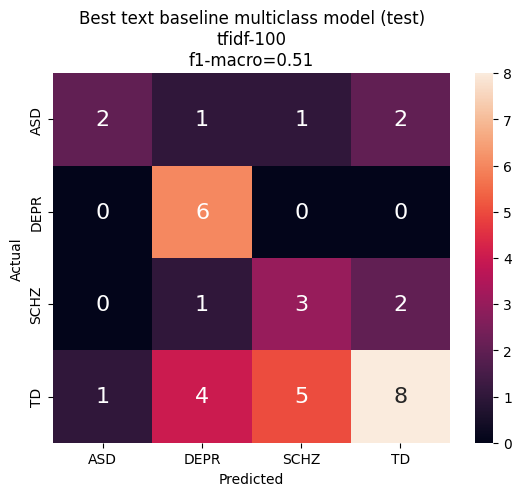

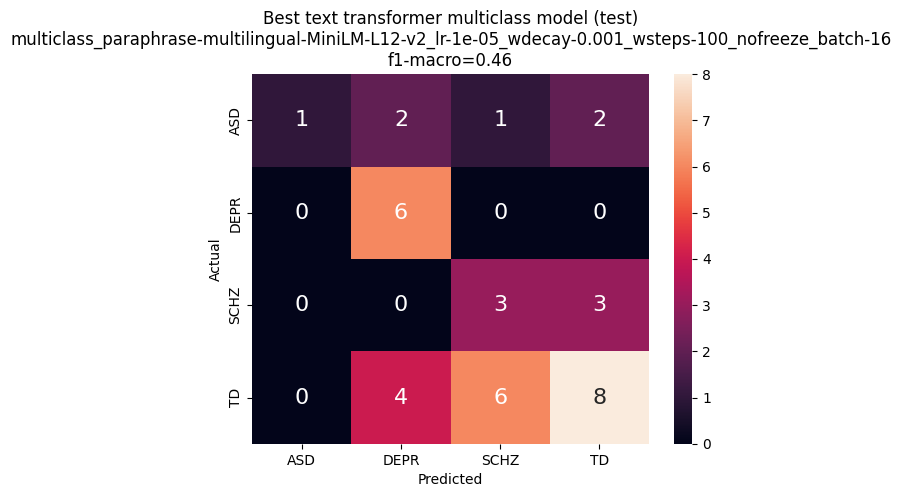

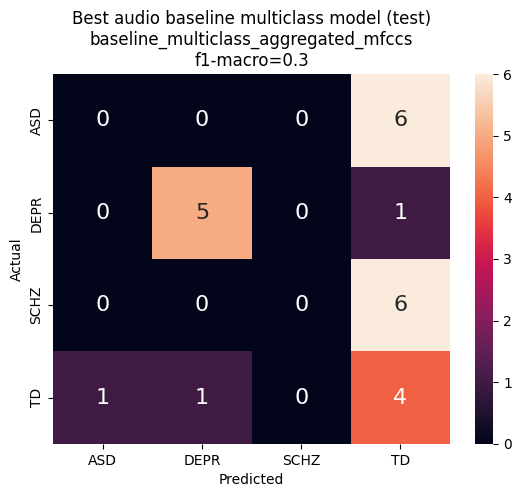

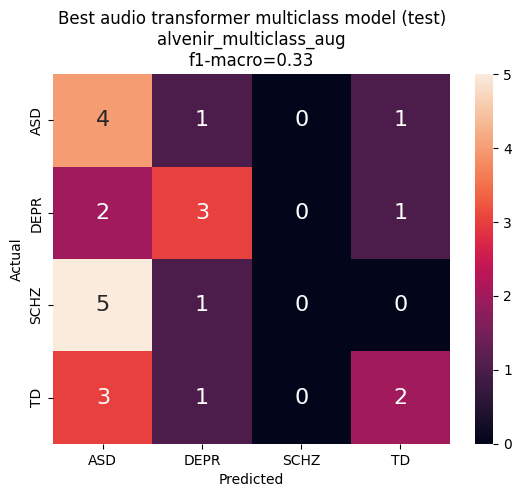

In [31]:
def get_conf_matrix(df, model_name, target_class="multiclass", split="test"):
    df = df[(df["score_type"] == "confusion_matrix") & (df["model_name"] == model_name) & (df["target_class"] == target_class) & (df["split"] == split)]
    conf_mat = df["value"]
    
    if len(conf_mat) > 1:
        raise ValueError("More than 1 confusion matrix returned. Subset better..")
    if target_class == "multiclass":
        idx_mapping = sorted(["TD", "DEPR", "ASD", "SCHZ"])
    else:
        idx_mapping = sorted(["TD", target_class])

    conf_mat = np.stack(df["value"]).squeeze()
    conf_df = pd.DataFrame(conf_mat, index=idx_mapping, columns=idx_mapping)

    return conf_df

def plot_conf_matrix(conf_matrix, title):        
    ax = plt.axes()
    sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16})
    ax.set_title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()    


best_multiclass_baseline_conf = get_conf_matrix(df, best_baseline_text_name)
title = f"Best text baseline multiclass model (test)\n{best_baseline_text_name}\nf1-macro={round(df.at[best_baseline_text_idx, 'value'],2)}"

plot_conf_matrix(best_multiclass_baseline_conf, title)


best_multiclass_transformer_conf = get_conf_matrix(df, best_transformer_text_name)
title = f"Best text transformer multiclass model (test)\n{best_transformer_text_name}\nf1-macro={round(df.at[best_transformer_text_idx, 'value'],2)}"

plot_conf_matrix(best_multiclass_transformer_conf, title)

best_multiclass_baseline_conf = get_conf_matrix(df, best_baseline_audio_name)
title = f"Best audio baseline multiclass model (test)\n{best_baseline_audio_name}\nf1-macro={round(df.at[best_baseline_audio_idx, 'value'],2)}"

plot_conf_matrix(best_multiclass_baseline_conf, title)


best_multiclass_transformer_conf = get_conf_matrix(df, best_transformer_audio_name)
title = f"Best audio transformer multiclass model (test)\n{best_transformer_audio_name}\nf1-macro={round(df.at[best_transformer_audio_idx, 'value'],2)}"

plot_conf_matrix(best_multiclass_transformer_conf, title)


